## NLP with Disaster Tweets

In [0]:
!pip install simpletransformers

In [0]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import torch
import torch.nn as nn
import os, re, string
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from simpletransformers.classification import ClassificationModel

In [0]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub_sample = pd.read_csv("sample_submission.csv")

print (train.shape, test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


## 1. Basic Exploration

In [0]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
train.duplicated().sum()

0

There are 52 duplicated rows. The duplicates will be removed.

In [0]:
train = train.drop_duplicates().reset_index(drop=True)

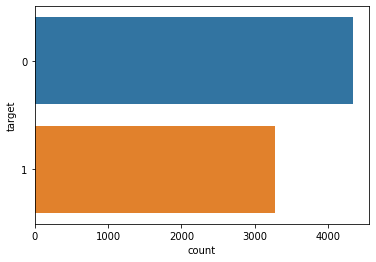

In [0]:
# Class balance
# train.target.value_counts()
sns.countplot(y=train.target);

In [0]:
# NA data
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [0]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Text is all non-null. Only a small percentage of tweets have no keyword. Location has much more null values.

## 2. EDA and Feature Engineering
### 2.1 Explore keyword column

In [0]:
# Check number of unique keywords, and whether they are the same for train and test sets
print (train.keyword.nunique(), test.keyword.nunique())
print (set(train.keyword.unique()) - set(test.keyword.unique()))

221 221
set()


In [0]:
train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', ..., 'wounds', 'wreck', 'wreckage', 'wrecked'], dtype=object)

- Train and test have the same set of keywords

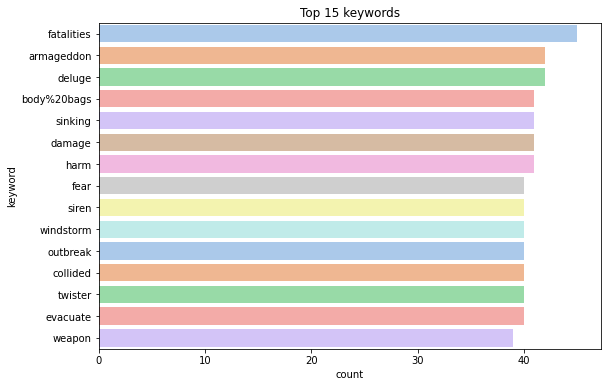

In [0]:
# Most common keywords
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:15].index,palette = 'pastel')
plt.title('Top 15 keywords')
plt.show()
# train.keyword.value_counts().head(10)

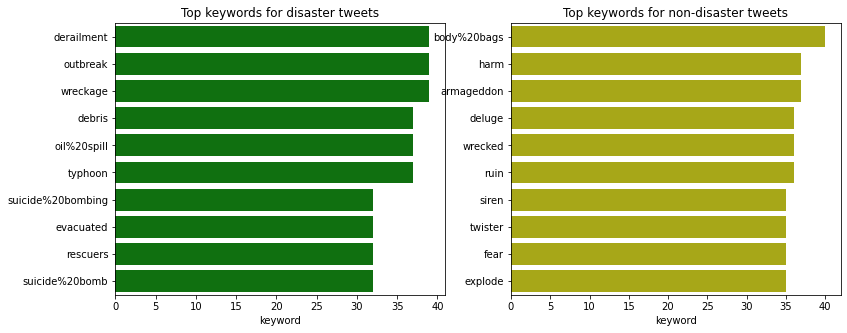

In [0]:
kw_d = train[train.target==1].keyword.value_counts().head(10)
kw_nd = train[train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='g')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

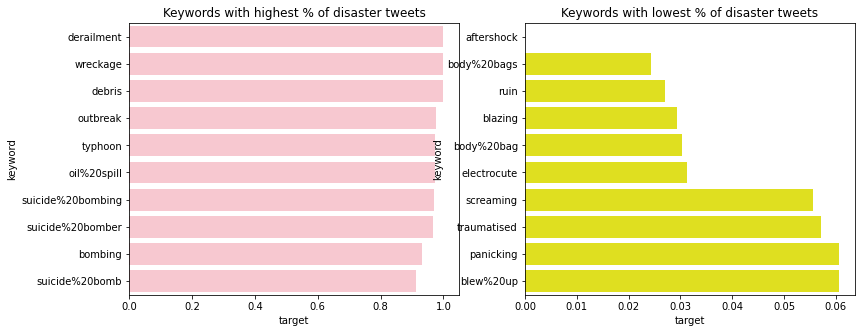

In [0]:
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='pink')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='yellow')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

- A function to clean the top ranking keywords 

In [0]:
def clean_keyword(keyword) :
    keyword = re.sub('^.*%20.*$',' ',str(keyword))
    keyword = re.sub('^.*fire.*$','fire',str(keyword))
    keyword = re.sub('^.*storm.*$','storm',str(keyword))
    keyword = re.sub('^.*emergency.*$','emergency',str(keyword))
    keyword = re.sub('^.*disaster.*$','disaster',str(keyword))
    keyword = re.sub('^.*collapse.*$','collapse',str(keyword))
    keyword = re.sub('^.*bombing.*$','bombing',str(keyword))
    keyword = re.sub('^.*bomb.*$','bomb',str(keyword))
    keyword = re.sub('^.*zone.*$','zone',str(keyword))
    keyword = re.sub('^.*bagging.*$','bagging',str(keyword))
    return keyword

train['keyword']=train['keyword'].apply(clean_keyword)
test['keyword']=test['keyword'].apply(clean_keyword)

### 2.2 Explore location column 

In [0]:
# Missing value
train['location'].isna().sum()

2533

In [0]:
# Unique values
train["location"].nunique()

3341

In [0]:
train[~train['location'].isna()]['location'].tolist()[10:20]

['GREENSBORO,NORTH CAROLINA',
 'Live On Webcam',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim',
 'Abuja',
 'USA',
 'South Africa']

- The location column has large number of missing values and unique values
-Contents in location column are not automatically generated, they are user inputs. That's why location is very dirty. It shouldn't be used as a feature.

In [0]:
# Drop location columns
train = train.drop('location',axis=1) 
test = test.drop('location',axis=1) 

### 2.3 Explore text column

In [0]:
train['text'].tolist()[30:60]

['The end!',
 '@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
 'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
 'Crying out for more! Set me ablaze',
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N',
 "@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.",
 'INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA',
 'Barbados #Bridgetown JAMAICA \x89ÛÒ Two cars set ablaze: SANTA CRUZ \x89ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J',
 'Ablaze for you Lord :D',
 'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw',
 "on the outside you're ablaze and alive\nbut you're dead inside",
 'Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida

- There are lots of URLs, hash tags and # in the text column.They could be used as one of the feature in our model
- Count number of #(hash tags) in a text

In [0]:
def hash_count(text):
    if not text:
        return -1
    return text.count("#")

train['hashtag_count'] = train['text'].apply(hash_count)
test['hashtag_count'] = test['text'].apply(hash_count)

- Count number of @(at signs) in a text

In [0]:
def at_count(text):
    if not text:
        return -1
    return text.count("@")

train['at_count'] = train['text'].apply(at_count)
test['at_count'] = test['text'].apply(at_count)

- Count numbers of URLs in a test

In [0]:
def url_count(text):
    if not text:
        return -1
    else:
      counts = re.findall('http', text,re.IGNORECASE)
    return len(counts)

train['url_count'] = train['text'].apply(url_count)
test['url_count'] = test['text'].apply(url_count)

- Count number of words

In [0]:
def word_count(text):
  if not text:
    return -1
  return len(str(text).split())

train['word_count'] = train['text'].apply(word_count)
test['word_count'] = test['text'].apply(word_count)

- Count numbers of keywords in a test 

In [0]:
def keyword_count(keywords, text):
    if not keywords[0]:
        return 0
    count = 0
    for keyword in keywords:
        each_keyword_count = text.count(str(keyword))
        count = count + each_keyword_count
    return count

train['keyword_count'] = train.apply(lambda col: keyword_count(col["keyword"] , col['text']), axis=1)
test['keyword_count'] = test.apply(lambda col: keyword_count(col["keyword"] , col['text']), axis=1)

- Clean text column for word embedding
 - Remove urls, emojis and punctuations

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text) 

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
train['text'] = train['text'].apply(remove_URL)
train['text'] = train['text'].apply(remove_emoji)
train['text'] = train['text'].apply(remove_punct)
train['text'] = train['text'].apply(remove_html)

In [0]:
test['text'] = test['text'].apply(remove_URL)
test['text'] = test['text'].apply(remove_emoji)
test['text'] = test['text'].apply(remove_punct)
test['text'] = test['text'].apply(remove_html)

## 3. Language model building

In [0]:
seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
train_nlp = train[['text', 'target']]

In [0]:
# Using 'bert-large-uncased' here. For a list of other models, please refer to 
# https://github.com/ThilinaRajapakse/simpletransformers/#current-pretrained-models 
bert_uncased = ClassificationModel('bert', 'bert-large-uncased') 

# Print out all the default arguments for reference
bert_uncased.args

{'adam_epsilon': 1e-08,
 'best_model_dir': 'outputs/best_model',
 'cache_dir': 'cache_dir/',
 'config': {},
 'do_lower_case': False,
 'early_stopping_consider_epochs': False,
 'early_stopping_delta': 0,
 'early_stopping_metric': 'eval_loss',
 'early_stopping_metric_minimize': True,
 'early_stopping_patience': 3,
 'encoding': None,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'evaluate_during_training_steps': 2000,
 'evaluate_during_training_verbose': False,
 'fp16': True,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 4e-05,
 'logging_steps': 50,
 'manual_seed': None,
 'max_grad_norm': 1.0,
 'max_seq_length': 128,
 'model_name': 'bert-large-uncased',
 'model_type': 'bert',
 'multiprocessing_chunksize': 500,
 'n_gpu': 1,
 'no_cache': False,
 'no_save': False,
 'num_train_epochs': 1,
 'output_dir': 'outputs/',
 'overwrite_output_dir': False,
 'process_count': 1,
 'regression': False,
 'reprocess_input_data': True,
 'save_best_model': True,
 '

In [0]:
# This is where we can tweak based on the default arguments above
custom_args = {'fp16': False, # not using mixed precision 
               'train_batch_size': 4, # default is 8
               'gradient_accumulation_steps': 2,
               'do_lower_case': True,
               'learning_rate': 1e-05, # using lower learning rate
               'overwrite_output_dir': True, # important for CV
               'num_train_epochs': 2} # default is 1

In [0]:
n=5
kf = KFold(n_splits=n, random_state=seed, shuffle=True)
results = []

for train_index, val_index in kf.split(train_nlp):
    train_df = train_nlp.iloc[train_index]
    val_df = train_nlp.iloc[val_index]
    
    model = ClassificationModel('bert', 'bert-base-uncased', args=custom_args) 
    model.train_model(train_df)
    result, model_outputs, wrong_predictions = model.eval_model(val_df, acc=sklearn.metrics.accuracy_score)
    print(result['acc'])
    results.append(result['acc'])

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:251: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.620118

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.105113


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.060305



/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:669: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."



0.8253447143795141


Running loss: 0.085642


Running loss: 0.030373




0.8233749179251477


Running loss: 0.517630


Running loss: 0.031609




0.8299409061063691


Running loss: 0.950044


Running loss: 0.049794




0.8423127463863338


Running loss: 0.167479


Running loss: 0.107397




0.842969776609724


In [0]:
for i, result in enumerate(results, 1):
    print(f"Fold-{i}: {result}")
    
print(f"{n}-fold CV accuracy result: Mean: {np.mean(results)} Standard deviation:{np.std(results)}")

Fold-1: 0.8253447143795141
Fold-2: 0.8233749179251477
Fold-3: 0.8299409061063691
Fold-4: 0.8423127463863338
Fold-5: 0.842969776609724
5-fold CV accuracy result: Mean: 0.8327886122814178 Standard deviation:0.008324709308979486


In [0]:
model = ClassificationModel('bert', 'bert-base-uncased', args=custom_args) 
model.train_model(train_nlp)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:251: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.623652

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.142565


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.062296



In [0]:
predictions, raw_outputs = model.predict(test['text'])


In [0]:
test['nlp_score'] = raw_outputs[:,1]

In [0]:
_, raw_outputs_t = model.predict(train['text'])

In [0]:
train['nlp_score'] = raw_outputs_t[:,1]

In [0]:
x_train = train.drop(columns=['id','keyword','text','target'],axis=1)
y_train = train['target']
x_test = test.drop(columns=['id','keyword','text'],axis=1)

### 4. Build model using LR and SVM 

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold, cross_val_score,RandomizedSearchCV,GridSearchCV
lr = LogisticRegression()

parameters = {'C': [0.5,1, 1.3, 1.5,2,5],'solver':['liblinear','lbfgs'],
            'max_iter':[200,400]}
gs_lr = GridSearchCV(lr, param_grid = parameters, n_jobs=-1, cv=5, scoring="accuracy")
gs_lr.fit(x_train, y_train)
print("Best parameters:", gs_lr.best_params_)

Best parameters: {'C': 0.5, 'max_iter': 200, 'solver': 'liblinear'}


In [0]:
lr = lr.set_params(**gs_lr.best_params_)
lr.fit(x_train, y_train)
y_test = lr.predict(x_test)

In [0]:
sub_sample['target'] = y_test
sub_sample.to_csv("submission2.csv", index=False)

In [0]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
gs_svm = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, scoring="accuracy").fit(x_train, y_train)

In [0]:
print("Best parameters:", gs_svm.best_params_)

Best parameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [0]:
svm = SVC(kernel='rbf',C = 100, gamma=0.0001)
svm.fit(x_train, y_train)
pred_SVM= svm.predict(x_test).astype(int)
# pred_SVM = pred_SVM.astype(int)

In [0]:
test['target'] = pred_SVM

submission3= test[['id','target']]
submission3.to_csv('submission3.csv',index=False)